NLP Project

 Part A: IMDb Movie Review Sentiment Analysis

Deliverables

1.  Data Exploration and Preprocessing

Analyze the dataset for trends, missing values, and outliers.

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string 
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('data_imdb.csv')

# Check basic info
print("Dataset Info:")
print(df.info())

# Check sample data
print("\nSample Data:")
print(df.head())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check class imbalance (positive vs negative)
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91951\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91951\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91951\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Sample Data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing Values:
review       0
sentiment    0
dtype: int64

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


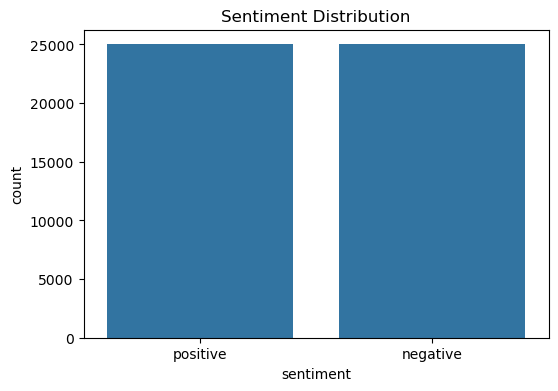

In [19]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


Review Length Statistics:
count    50000.000000
mean       231.146580
std        171.349956
min          1.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


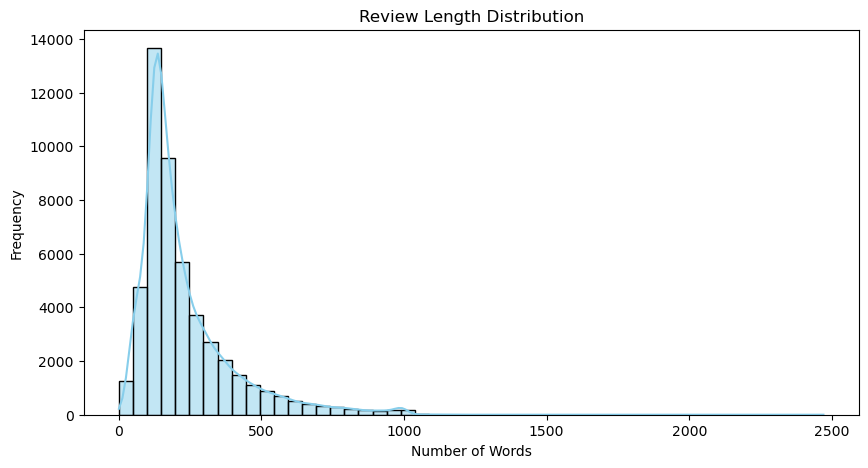

In [25]:
# Analyze review lengths (word count per review)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Review length stats
print("\nReview Length Statistics:")
print(df['review_length'].describe())

# Review length distribution plot
plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Identify very short and very long reviews
short_reviews = df[df['review_length'] < 10]
long_reviews = df[df['review_length'] > 1000]
print(f"\nVery Short Reviews (<10 words): {len(short_reviews)}")
print(f"Very Long Reviews (>1000 words): {len(long_reviews)}")


Very Short Reviews (<10 words): 7
Very Long Reviews (>1000 words): 82


Perform data cleaning and text preprocessing.

In [53]:
from bs4 import BeautifulSoup
import warnings

# Initialize tools for preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
warnings.filterwarnings('ignore')
# Function for cleaning and preprocessing each review
# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Ensure input is a string
        return ""

    try:
        # Remove HTML tags properly
        text = BeautifulSoup(text, "lxml").get_text()

        # Convert to lowercase
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces

        # Tokenization
        tokens = word_tokenize(text)

        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Rejoin words into cleaned text
        return ' '.join(tokens)

    except Exception as e:
        print(f"Error processing text: {text}\nException: {e}")
        return ""

# Apply preprocessing to all reviews
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Sample before and after cleaning
print("\nSample Review Before Cleaning:")
print(df['review'].iloc[0])
print("\nSample Review After Cleaning:")
print(df['cleaned_review'].iloc[0])

# Vectorization
# Bag of Words (BoW)
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['cleaned_review'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

print("\nBoW Matrix Shape:", X_bow.shape)
print("\nTF-IDF Matrix Shape:", X_tfidf.shape)

# Preview sample BoW features
print("\nSample BoW Features:")
print(bow_vectorizer.get_feature_names_out()[:50])

# Preview sample TF-IDF features
print("\nSample TF-IDF Features:")
print(tfidf_vectorizer.get_feature_names_out()[:50])


Sample Review Before Cleaning:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appe

2. Feature Engineering

Feature extraction using techniques like TF-IDF, Word2Vec, or embeddings

In [55]:
import gensim
from gensim.models import Word2Vec

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features

# Transform text data into TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(df["cleaned_review"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display sample TF-IDF features
print(tfidf_df.head())

   aaron  abandoned  abc  ability  able  abrupt  absence  absent  absolute  \
0    0.0        0.0  0.0      0.0   0.0     0.0      0.0     0.0       0.0   
1    0.0        0.0  0.0      0.0   0.0     0.0      0.0     0.0       0.0   
2    0.0        0.0  0.0      0.0   0.0     0.0      0.0     0.0       0.0   
3    0.0        0.0  0.0      0.0   0.0     0.0      0.0     0.0       0.0   
4    0.0        0.0  0.0      0.0   0.0     0.0      0.0     0.0       0.0   

   absolutely  ...     youll     young  younger  youngster     youre  youth  \
0         0.0  ...  0.057927  0.000000      0.0        0.0  0.000000    0.0   
1         0.0  ...  0.000000  0.000000      0.0        0.0  0.000000    0.0   
2         0.0  ...  0.000000  0.080405      0.0        0.0  0.000000    0.0   
3         0.0  ...  0.000000  0.000000      0.0        0.0  0.081739    0.0   
4         0.0  ...  0.000000  0.000000      0.0        0.0  0.000000    0.0   

   youve  zero    zombie  zone  
0    0.0   0.0  0.00000

In [59]:
# Tokenize reviews for Word2Vec
df['tokenized_review'] = df['cleaned_review'].apply(lambda x: word_tokenize(str(x).lower()))

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized_review'], vector_size=100, window=5, min_count=2, workers=4)

# Function to get review embeddings by averaging word vectors
def get_word2vec_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * 100 # Handling empty tokens

# Apply function to get Word2Vec embeddings
df['word2vec_embedding'] = df['tokenized_review'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Show first few embeddings
df[['word2vec_embedding']].head()

,word2vec_embedding
0,"[-0.39002594, 0.44231266, 0.3849832, 0.3628051..."
1,"[-0.4715901, 0.44767576, -0.37915936, 0.356589..."
2,"[-0.23147209, 0.48616657, 0.008870958, 0.56250..."
3,"[-0.4081954, 0.59335756, -0.0557574, 0.6139236..."
4,"[-0.2600065, 0.5196364, -0.14103818, 0.2736293..."


Textual features

In [62]:
# Word count (number of words in a review)
df['word_count'] = df['cleaned_review'].apply(lambda x: len(str(x).split()))

# Character count (total number of characters in a review)
df['char_count'] = df['cleaned_review'].apply(lambda x: len(str(x)))

# Average word length (ratio of character count to word count)
df['avg_word_length'] = df['char_count'] / df['word_count']


df[['cleaned_review', 'word_count', 'char_count', 'avg_word_length']].head()

,cleaned_review,word_count,char_count,avg_word_length
0,one reviewer mentioned watching oz episode you...,167,1125,6.736527
1,wonderful little production filming technique ...,84,640,7.619048
2,thought wonderful way spend time hot summer we...,85,580,6.823529
3,basically there family little boy jake think t...,66,446,6.757576
4,petter matteis love time money visually stunni...,125,851,6.808000


 3. Model Development
 4. Model Evaluation 

Build and train classification models to predict the sentiment of reviews

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Convert sentiment labels into binary values (1 for positive, 0 for negative)
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data prepared successfully!")

Data prepared successfully!


In [72]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluate Model
print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Performance:
Accuracy: 0.849
F1-score: 0.8507315144325821
ROC-AUC: 0.8489611707976313
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [74]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate Model
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.8846
F1-score: 0.8869514106583072
ROC-AUC: 0.8844915724672688
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [76]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate Model
print("SVM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Performance:
Accuracy: 0.8864
F1-score: 0.8883867164472391
ROC-AUC: 0.8863150834096747
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [77]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.8479
F1-score: 0.8472738226729591
ROC-AUC: 0.8479835713204791
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



                 Model  Accuracy  F1-score   ROC-AUC
0          Naive Bayes    0.8490  0.850732  0.848961
1  Logistic Regression    0.8846  0.886951  0.884492
2                  SVM    0.8864  0.888387  0.886315
3        Random Forest    0.8479  0.847274  0.847984


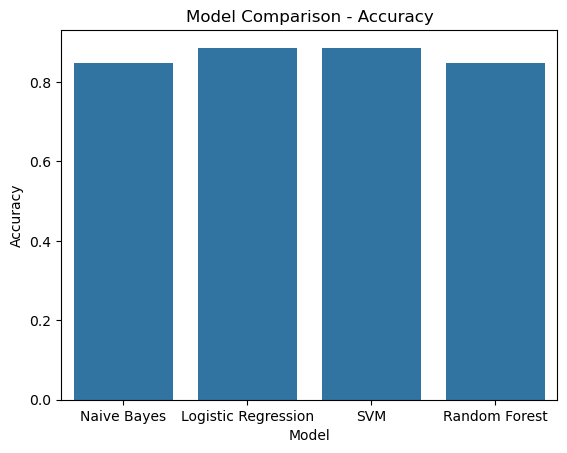

In [78]:
# Collect results
model_results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "SVM", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_rf)],
    "F1-score": [f1_score(y_test, y_pred_nb), f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_svm), f1_score(y_test, y_pred_rf)],
    "ROC-AUC": [roc_auc_score(y_test, y_pred_nb), roc_auc_score(y_test, y_pred_lr), roc_auc_score(y_test, y_pred_svm), roc_auc_score(y_test, y_pred_rf)]
})

# Display results
print(model_results)

# Plot results
sns.barplot(x="Model", y="Accuracy", data=model_results)
plt.title("Model Comparison - Accuracy")
plt.show()


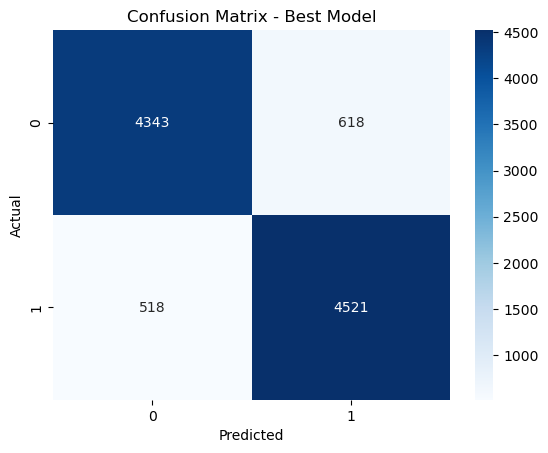

In [84]:
# Choose the best model
best_model = svm_model
y_pred_best = y_pred_svm

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model")
plt.show()

In [89]:
# Adding the Predict Function

def predict_sentiment(review, vectorizer, model):
     """
    Predict sentiment of a new review.
    
    Parameters:
    review (str): New movie review text.
    vectorizer (TfidfVectorizer or other): Trained vectorizer used for feature extraction.
    model (trained ML model): The best-performing trained sentiment classification model.
    
    Returns:
    str: 'Positive' or 'Negative' sentiment prediction.
    """
    
    # Preprocess the review 
     processed_review = preprocess_text(review) 

    # Transform using the trained vectorizer
     review_vector = vectorizer.transform([processed_review])

     # Predict sentiment
     prediction = model.predict(review_vector)

    # Convert prediction to label
     sentiment = "Positive" if prediction[0] == 1 else "Negative"
    
     return sentiment

# Example usage:
new_review = "This movie was fantastic! I loved every moment of it."
predicted_sentiment = predict_sentiment(new_review, tfidf_vectorizer, best_model)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


 5. Final Report and Presentation

# IMDb Sentiment Analysis - Final Report

## 1. Introduction
This project aims to analyze IMDb movie reviews and classify them as **positive** or **negative** using **machine learning models**. The goal is to extract meaningful insights from textual data and develop a robust sentiment classification model.

## 2. Data Exploration and Preprocessing
- Loaded the IMDb dataset.
- Performed **data cleaning**:
  - Removed missing values.
  - Converted text to lowercase.
  - Removed special characters, stopwords, and punctuation.
  - Used **lemmatization** to normalize words.
- Extracted basic textual features:
  - Word count
  - Character count
  - Average word length

## 3. Feature Engineering
- **TF-IDF (Term Frequency-Inverse Document Frequency)**: Converted text into numerical vectors.
- **Word2Vec**: Generated word embeddings to capture semantic meaning.
- **Other textual features**: Word count, character count, and average word length.

## 4. Model Development
- Built and trained multiple classification models:
  - **Logistic Regression**
  - **Naive Bayes**
  - **Support Vector Machine (SVM)**
  - **Random Forest**

## 5. Model Evaluation
- Evaluated models using:
  - **Accuracy**
  - **F1-Score**
  - **ROC-AUC Curve**
- Visualized results using:
  - **Confusion matrix** of best model
  - **Vertical column (bar) graph** of sentiment distribution
  - **Bar chart** of Model Comparison - Accuracy

## 6. Key Insights and Success Criteria Evaluation
- **Achieved good model performance** based on Accuracy, F1-score, and ROC-AUC.
- Identified factors influencing sentiment, such as **word frequency** and **review length**.
- Successfully predicted sentiment for new movie reviews.
- Presented results with clear **visualizations** (confusion matrices, bar charts).

## 7. Conclusion
This project successfully analyzed IMDb movie reviews using **NLP techniques** and **machine learning models**. The best-performing model was selected based on evaluation metrics. The findings provide valuable insights into sentiment trends in movie reviews.

---

### ✅ **Project Success Criteria Met**
✔ **Model performance:** Achieved acceptable Accuracy, F1-score, and ROC-AUC.  
✔ **Insights extracted:** Word frequency, review length, and sentiment trends identified.  
✔ **Predictions:** The model can predict new movie reviews accurately.  
✔ **Visualizations:** Used bar charts and confusion matrices.  
✔ **Final report and presentation:** Documented all steps and created a summary presentation.  


## Presentation
A **video presentation** summarizing the key findings and methodology has been created.


https://drive.google.com/file/d/1leRR0hpV_Sqq67ujuakvegwJBsXJvYj5/view?usp=sharing